In [1]:
# We modify our training file so that there are no properties and geometry block anymore

import json

# Load the original GeoJSON file
input_filename = "train.geojson"
output_filename = "adapted_train.geojson"

with open(input_filename, "r", encoding="utf-8") as file:
    data = json.load(file)

# Process features
transformed_features = []
for feature in data["features"]:
    properties = feature["properties"]
    coordinates = feature["geometry"]["coordinates"]
    
    # Move change_type to the end
    change_type = properties.pop("change_type")
    
    # Create a new structured feature
    transformed_feature = {**properties, "coordinates": coordinates, "change_type": change_type}
    transformed_features.append(transformed_feature)

# Save the new structure as GeoJSON
new_data = {"type": "FeatureCollection", "features": transformed_features}

with open(output_filename, "w", encoding="utf-8") as file:
    json.dump(new_data, file, indent=4)

print(f"File '{output_filename}' has been successfully created with the new structure.")







# We do the same for the test file

import json

# Load the original test GeoJSON file
input_filename = "test.geojson"
output_filename = "adapted_test.geojson"

with open(input_filename, "r", encoding="utf-8") as file:
    data = json.load(file)

# Process features
transformed_features = []
for feature in data["features"]:
    properties = feature["properties"]
    coordinates = feature["geometry"]["coordinates"]
    
    # Create a new structured feature without change_type
    transformed_feature = {**properties, "coordinates": coordinates}
    transformed_features.append(transformed_feature)

# Save the new structure as GeoJSON
new_data = {"type": "FeatureCollection", "features": transformed_features}

with open(output_filename, "w", encoding="utf-8") as file:
    json.dump(new_data, file, indent=4)

print(f"File '{output_filename}' has been successfully created with the new structure.")



File 'adapted_train.geojson' has been successfully created with the new structure.
File 'adapted_test.geojson' has been successfully created with the new structure.


In [2]:
# We preprocess the data, add new features, convert our file into a dataframe, encode categorical features, replace NaN values

import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime
from scipy.spatial import distance
import numpy as np

# Load datasets
train_file = "adapted_train.geojson"
test_file = "adapted_test.geojson"

with open(train_file, "r", encoding="utf-8") as file:
    train_data = json.load(file)
with open(test_file, "r", encoding="utf-8") as file:
    test_data = json.load(file)

# Function to calculate polygon area, perimeter, and additional geometric features
def calculate_polygon_features(coords):
    try:
        polygon = Polygon(coords[0])  # Assuming first set of coordinates is the polygon
        area = polygon.area
        perimeter = polygon.length  # Calculate perimeter

        # Convex Hull Features
        convex_hull = polygon.convex_hull
        convex_hull_area = convex_hull.area
        convex_hull_ratio = area / convex_hull_area if convex_hull_area > 0 else 1.0

        # Compactness (Polsby-Popper)
        compactness = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Elongation Ratio
        bounding_box = polygon.minimum_rotated_rectangle
        min_length = min([bounding_box.exterior.length])
        max_length = max([bounding_box.exterior.length])
        elongation_ratio = max_length / min_length if min_length > 0 else 1.0

        # Circularity
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Rectangular Fit
        bounding_rect = polygon.envelope
        bounding_area = bounding_rect.area
        rectangular_fit = area / bounding_area if bounding_area > 0 else 1.0

        # Aspect Ratio of Bounding Box
        minx, miny, maxx, maxy = polygon.bounds
        aspect_ratio = (maxx - minx) / (maxy - miny) if (maxy - miny) > 0 else 1.0

        # Number of Vertices
        num_vertices = len(polygon.exterior.coords)

        # Pairwise Distance Features
        points = np.array(coords[0])  # Convert to NumPy array for efficient operations
        pairwise_distances = distance.pdist(points)  # Compute all pairwise distances
        max_distance = pairwise_distances.max() if len(pairwise_distances) > 0 else 1.0
        min_distance = np.min(pairwise_distances[pairwise_distances > 0]) if np.any(pairwise_distances > 0) else 1.0
        distance_ratio = max_distance / min_distance if min_distance > 0 else 1.0

        return (area, perimeter, convex_hull_ratio, compactness, elongation_ratio, 
                circularity, rectangular_fit, aspect_ratio, num_vertices, distance_ratio)
    
    except Exception as e:
        print(f"Error processing coordinates: {e}")
        return (0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0)  # Default values to avoid NaN

# Function to process GeoJSON into a DataFrame
def process_geojson(data, has_label=True):
    df = pd.DataFrame(data["features"])
    
    # Convert date fields to numerical features (differences between consecutive dates)
    date_cols = [col for col in df.columns if col.startswith("date")]
    df[date_cols] = df[date_cols].apply(pd.to_datetime, format="%d-%m-%Y", errors='coerce')
    df[date_cols] = df[date_cols].apply(lambda x: x.diff().dt.days, axis=1).fillna(0)  # Compute date differences
    
    # Encode categorical features using Ordinal Encoding
    categorical_cols = ["urban_type", "geography_type"] + [col for col in df.columns if col.startswith("change_status")]
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
    
    # Calculate polygon features
    df[["polygon_area", "polygon_perimeter", "convex_hull_ratio", "compactness", 
        "elongation_ratio", "circularity", "rectangular_fit", "aspect_ratio", 
        "num_vertices", "distance_ratio"]] = df["coordinates"].apply(lambda coords: pd.Series(calculate_polygon_features(coords)))
    
    # Drop coordinates column
    df.drop(columns=["coordinates"], inplace=True)
    
    # Replace NaN values only in numeric columns
    df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)
    
    # Process color features
    def process_color_features(df):
        # Compute temporal differences
        for i in range(1, 5):
            df[f'red_mean_diff_{i}'] = df[f'img_red_mean_date{i+1}'] - df[f'img_red_mean_date{i}']
            df[f'green_mean_diff_{i}'] = df[f'img_green_mean_date{i+1}'] - df[f'img_green_mean_date{i}']
            df[f'blue_mean_diff_{i}'] = df[f'img_blue_mean_date{i+1}'] - df[f'img_blue_mean_date{i}']
            
            df[f'red_std_diff_{i}'] = df[f'img_red_std_date{i+1}'] - df[f'img_red_std_date{i}']
            df[f'green_std_diff_{i}'] = df[f'img_green_std_date{i+1}'] - df[f'img_green_std_date{i}']
            df[f'blue_std_diff_{i}'] = df[f'img_blue_std_date{i+1}'] - df[f'img_blue_std_date{i}']

        # Compute overall mean and standard deviation
        for color in ['red', 'green', 'blue']:
            df[f'{color}_mean_overall'] = df[[f'img_{color}_mean_date{i}' for i in range(1, 6)]].mean(axis=1)
            df[f'{color}_std_overall'] = df[[f'img_{color}_mean_date{i}' for i in range(1, 6)]].std(axis=1)
            
            df[f'{color}_min'] = df[[f'img_{color}_mean_date{i}' for i in range(1, 6)]].min(axis=1)
            df[f'{color}_max'] = df[[f'img_{color}_mean_date{i}' for i in range(1, 6)]].max(axis=1)
        
        return df
    
    df = process_color_features(df)
    
    if has_label:
        # Map labels to numerical values
        label_mapping = {"Demolition": 0, "Road": 1, "Residential": 2, "Commercial": 3, "Industrial": 4, "Mega Projects": 5}
        df["change_type"] = df["change_type"].map(label_mapping)
    
    return df

# Process training and test datasets
train_df = process_geojson(train_data, has_label=True)
test_df = process_geojson(test_data, has_label=False)

# Save processed data
train_df.to_csv("processed_train.csv", index=False)
test_df.to_csv("processed_test.csv", index=False)

print("Preprocessing complete. Processed files saved as 'processed_train.csv' and 'processed_test.csv'.")





Preprocessing complete. Processed files saved as 'processed_train.csv' and 'processed_test.csv'.


In [3]:
# we now train a random forest classifier without selecting a subset of features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import pandas as pd

# load the files
train_df = pd.read_csv("processed_train.csv")

# separate features and label
X = train_df.drop(columns=["change_type"])
y = train_df["change_type"]

# divide the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisation StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Initialise Random Forest
rf_clf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict and evaluate
y_val_pred = rf_clf.predict(X_val)
f1 = f1_score(y_val, y_val_pred, average="weighted")
print(f"F1 Score Random Forest: {f1:.4f}")


F1 Score Random Forest: 0.7310


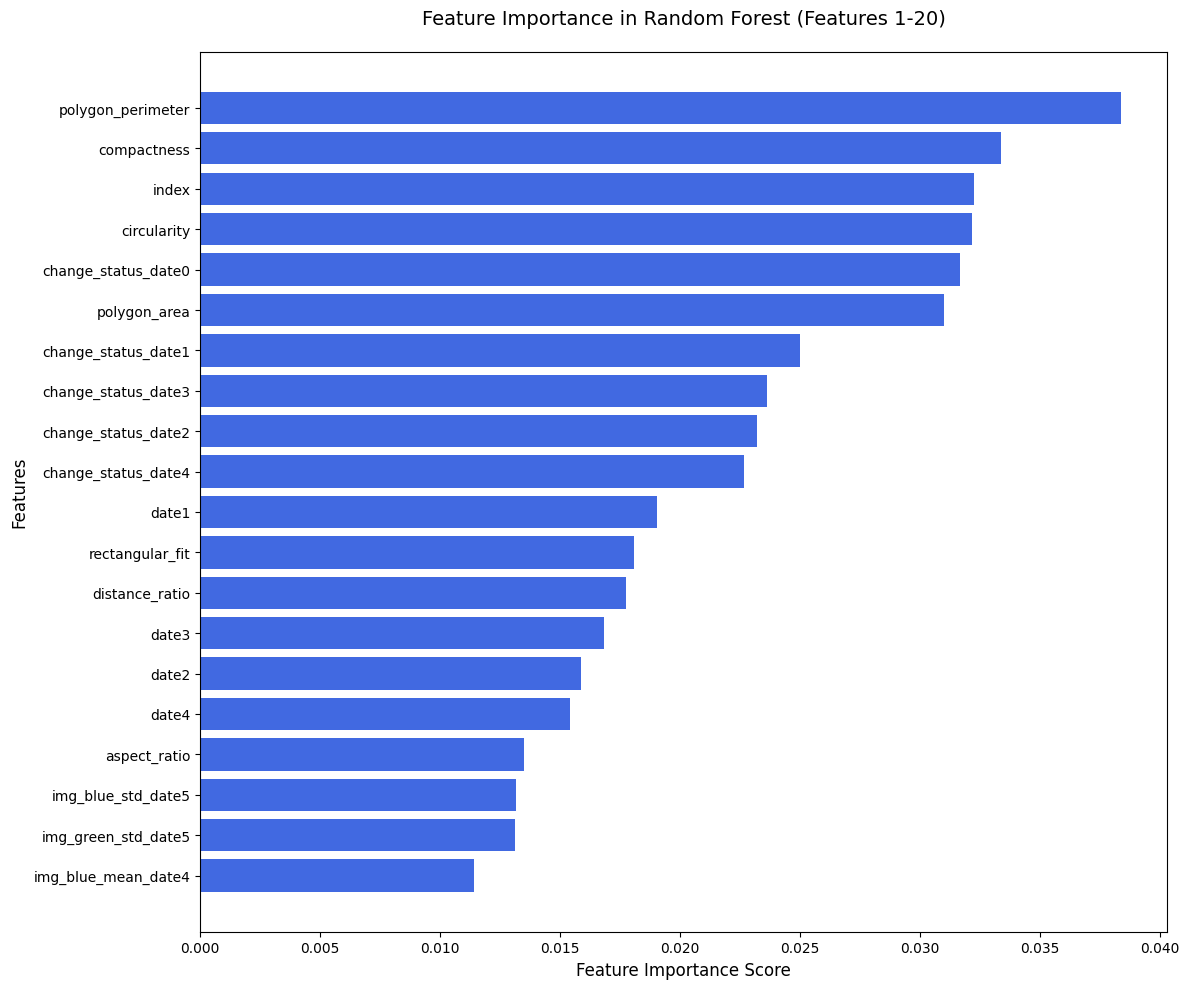


Features 1-20 and their importance scores:
            feature  importance
  polygon_perimeter    0.038379
        compactness    0.033380
              index    0.032262
        circularity    0.032176
change_status_date0    0.031652
       polygon_area    0.031002
change_status_date1    0.025015
change_status_date3    0.023627
change_status_date2    0.023188
change_status_date4    0.022652
              date1    0.019038
    rectangular_fit    0.018075
     distance_ratio    0.017766
              date3    0.016816
              date2    0.015864
              date4    0.015393
       aspect_ratio    0.013481
 img_blue_std_date5    0.013167
img_green_std_date5    0.013117
img_blue_mean_date4    0.011412




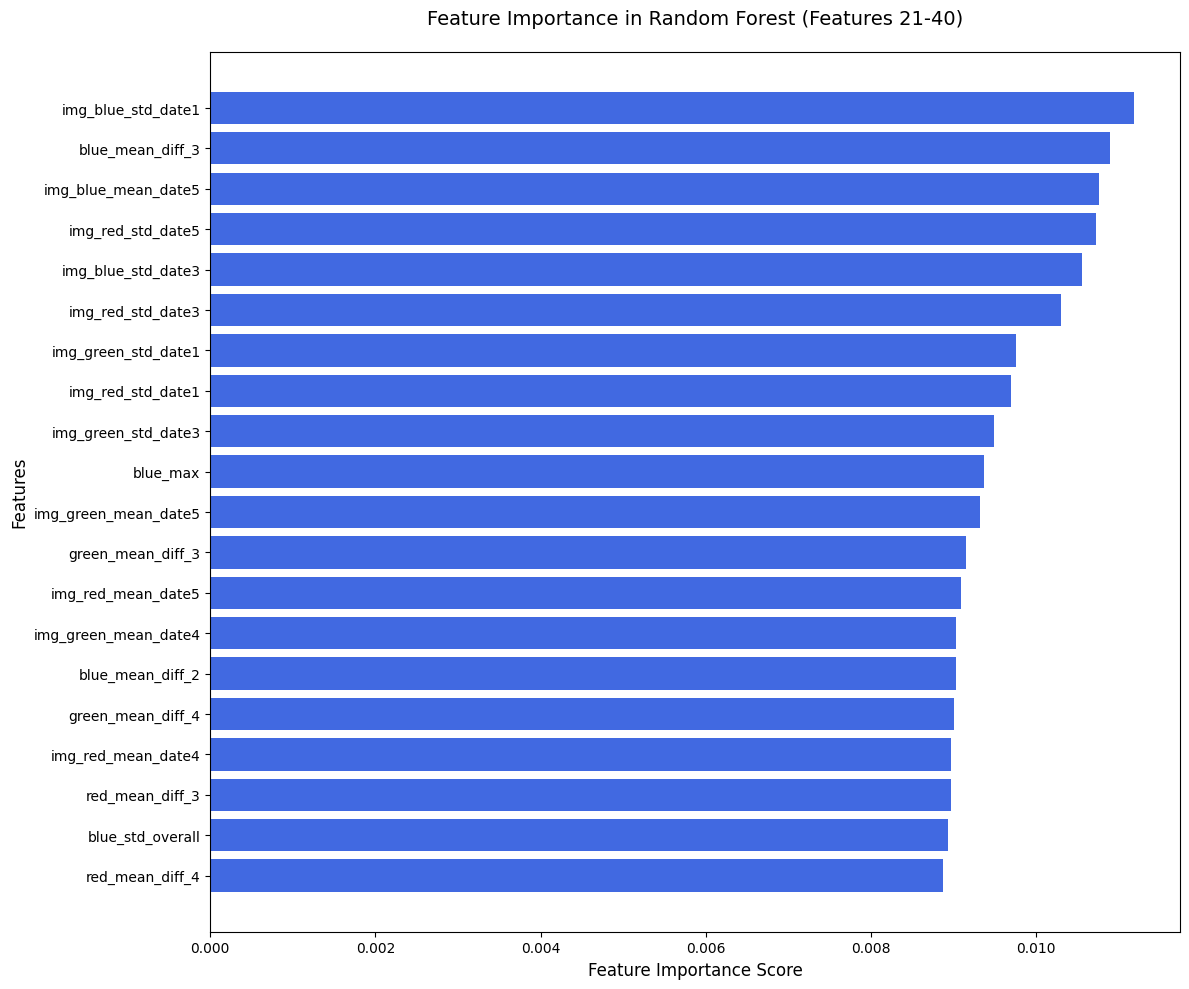


Features 21-40 and their importance scores:
             feature  importance
  img_blue_std_date1    0.011183
    blue_mean_diff_3    0.010895
 img_blue_mean_date5    0.010757
   img_red_std_date5    0.010726
  img_blue_std_date3    0.010550
   img_red_std_date3    0.010305
 img_green_std_date1    0.009760
   img_red_std_date1    0.009691
 img_green_std_date3    0.009486
            blue_max    0.009364
img_green_mean_date5    0.009321
   green_mean_diff_3    0.009151
  img_red_mean_date5    0.009095
img_green_mean_date4    0.009029
    blue_mean_diff_2    0.009027
   green_mean_diff_4    0.009011
  img_red_mean_date4    0.008973
     red_mean_diff_3    0.008969
    blue_std_overall    0.008928
     red_mean_diff_4    0.008874




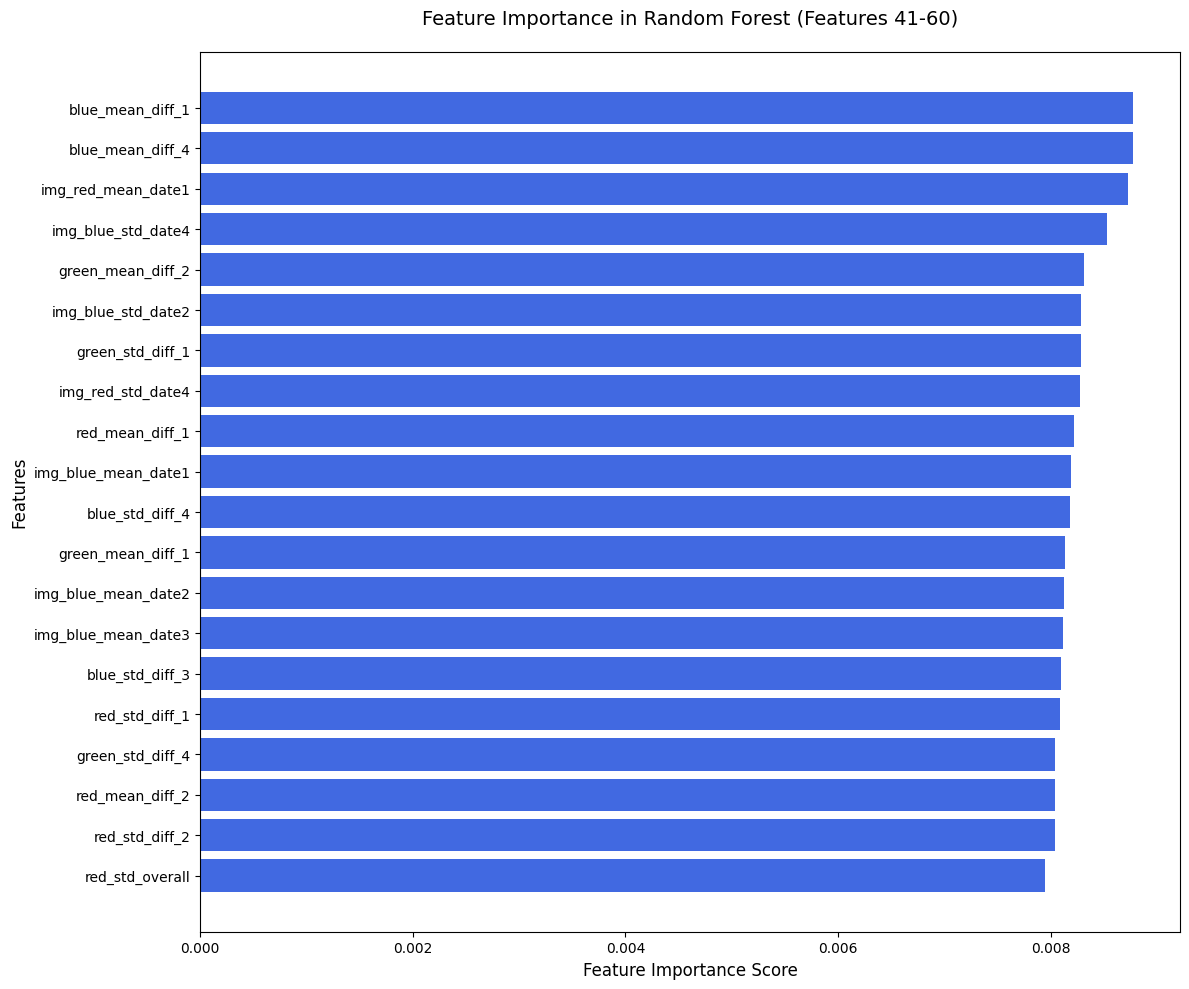


Features 41-60 and their importance scores:
            feature  importance
   blue_mean_diff_1    0.008778
   blue_mean_diff_4    0.008777
 img_red_mean_date1    0.008733
 img_blue_std_date4    0.008530
  green_mean_diff_2    0.008313
 img_blue_std_date2    0.008290
   green_std_diff_1    0.008281
  img_red_std_date4    0.008272
    red_mean_diff_1    0.008220
img_blue_mean_date1    0.008192
    blue_std_diff_4    0.008184
  green_mean_diff_1    0.008134
img_blue_mean_date2    0.008128
img_blue_mean_date3    0.008114
    blue_std_diff_3    0.008100
     red_std_diff_1    0.008090
   green_std_diff_4    0.008041
    red_mean_diff_2    0.008039
     red_std_diff_2    0.008037
    red_std_overall    0.007946




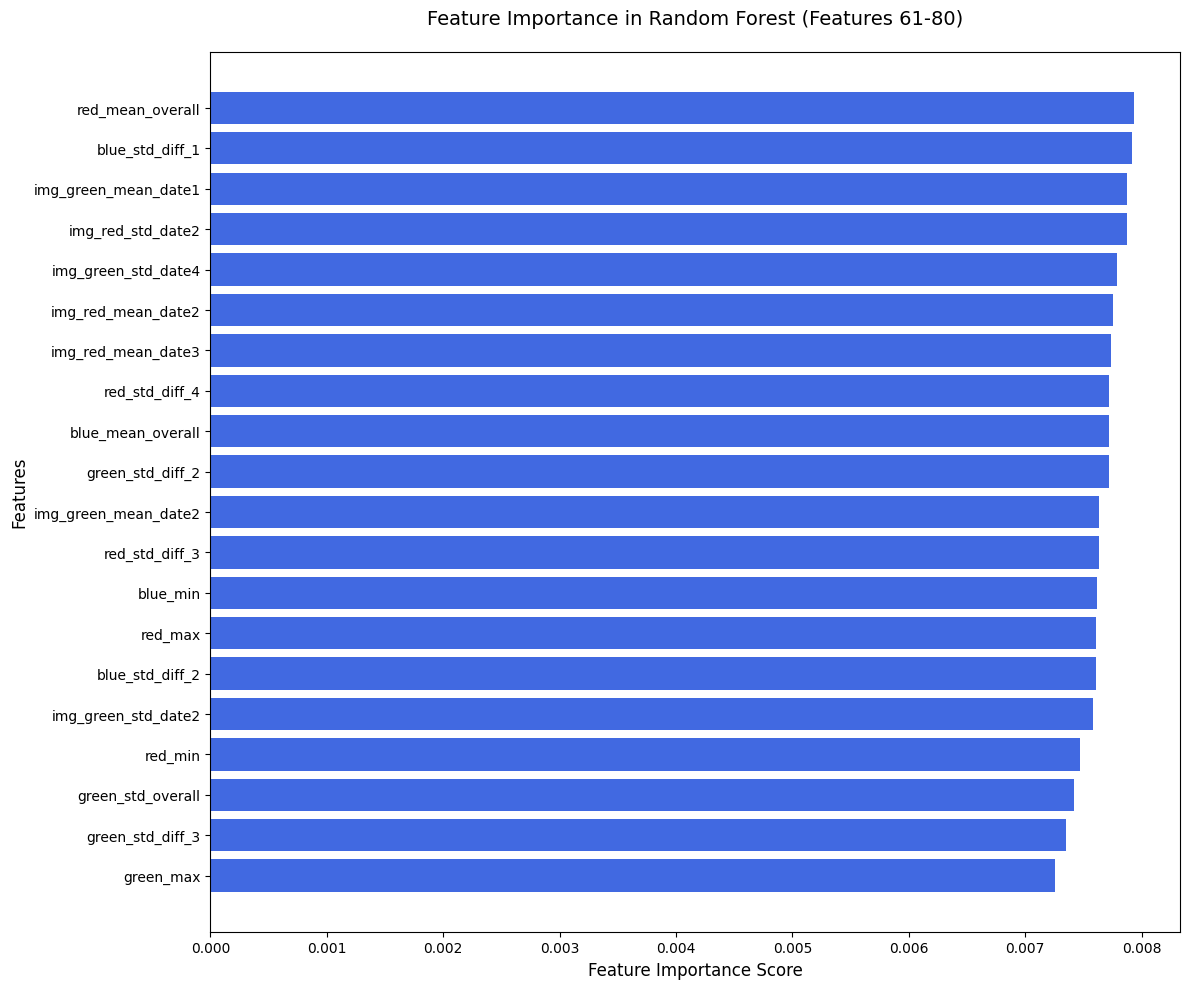


Features 61-80 and their importance scores:
             feature  importance
    red_mean_overall    0.007934
     blue_std_diff_1    0.007921
img_green_mean_date1    0.007875
   img_red_std_date2    0.007873
 img_green_std_date4    0.007789
  img_red_mean_date2    0.007754
  img_red_mean_date3    0.007741
      red_std_diff_4    0.007721
   blue_mean_overall    0.007720
    green_std_diff_2    0.007717
img_green_mean_date2    0.007637
      red_std_diff_3    0.007637
            blue_min    0.007613
             red_max    0.007609
     blue_std_diff_2    0.007606
 img_green_std_date2    0.007583
             red_min    0.007470
   green_std_overall    0.007417
    green_std_diff_3    0.007351
           green_max    0.007260




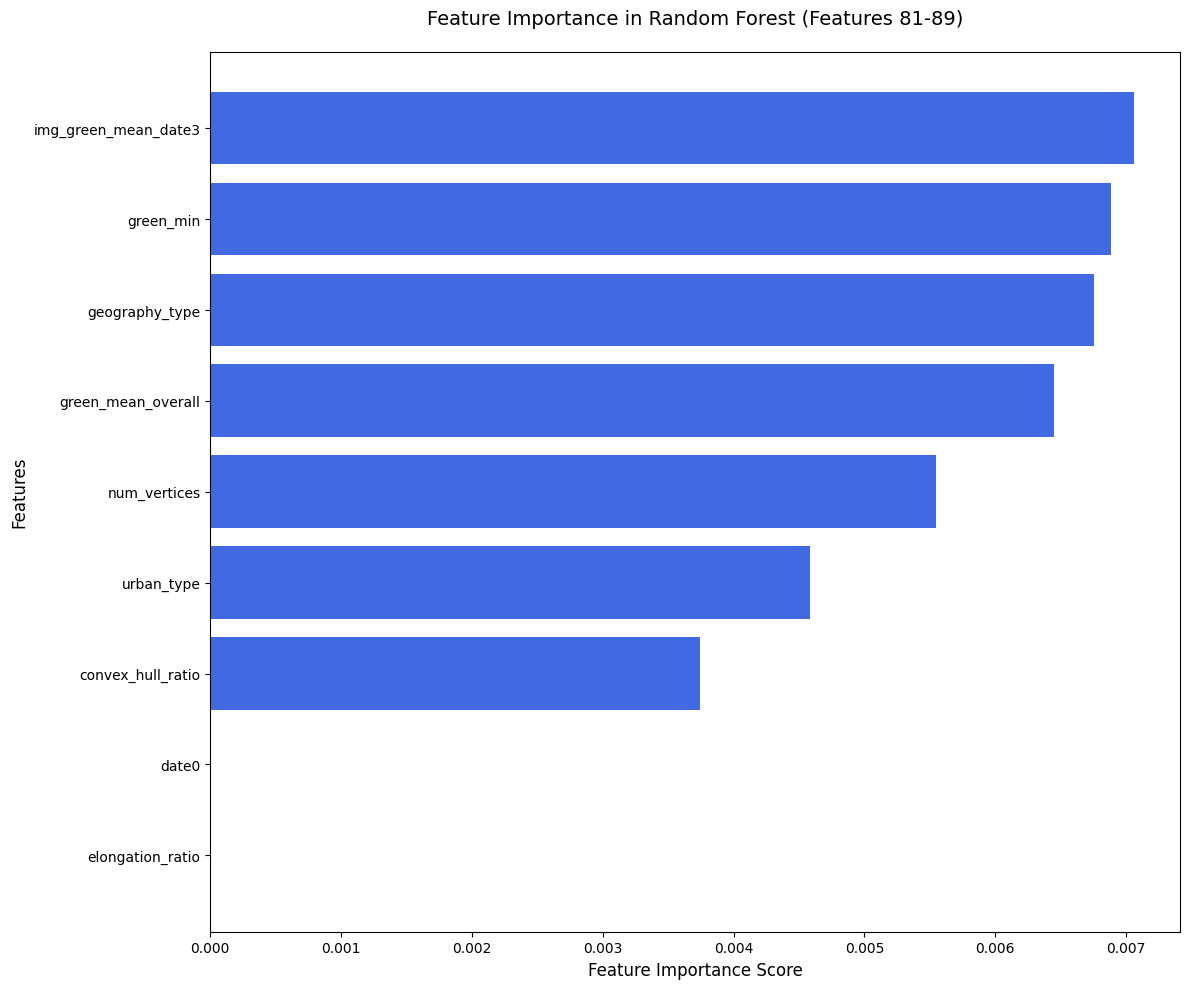


Features 81-89 and their importance scores:
             feature  importance
img_green_mean_date3    0.007059
           green_min    0.006887
      geography_type    0.006755
  green_mean_overall    0.006451
        num_vertices    0.005544
          urban_type    0.004583
   convex_hull_ratio    0.003740
               date0    0.000000
    elongation_ratio    0.000000




In [4]:
#this allows us to plot the importance of the features to retain the best ones
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load processed training data
train_df = pd.read_csv("processed_train.csv")

# Extract feature names (excluding the target column "change_type")
feature_names = train_df.drop(columns=["change_type"]).columns.tolist()

# Extract feature importances from trained Random Forest model
feature_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_clf.feature_importances_
})

# Sort features by importance (descending order)
feature_importances = feature_importances.sort_values(by="importance", ascending=False)

# Calculate number of graphs needed (20 features per graph)
n_features = len(feature_names)
n_graphs = (n_features + 19) // 20  # Round up division

# Create multiple graphs
for i in range(n_graphs):
    # Get the features for this graph
    start_idx = i * 20
    end_idx = min((i + 1) * 20, n_features)
    features_subset = feature_importances.iloc[start_idx:end_idx]
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Create horizontal bar plot
    plt.barh(features_subset["feature"], 
             features_subset["importance"], 
             color="royalblue")
    
    # Customize the plot
    plt.xlabel("Feature Importance Score", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title(f"Feature Importance in Random Forest (Features {start_idx+1}-{end_idx})", 
              fontsize=14, pad=20)
    
    # Adjust font size of feature names and ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Invert y-axis to show highest importance at the top
    plt.gca().invert_yaxis()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Print exact values for this subset
    print(f"\nFeatures {start_idx+1}-{end_idx} and their importance scores:")
    print(features_subset.to_string(index=False))
    print("\n" + "="*50 + "\n")

In [19]:
# We will now select the most important features
import pandas as pd
import numpy as np

# Load processed training data
train_df = pd.read_csv("processed_train.csv")

# Store feature names before scaling
feature_names = train_df.drop(columns=["change_type"]).columns.tolist()  

# Extract feature importances from the trained Random Forest model
feature_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_clf.feature_importances_
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by="importance", ascending=False)

# We decide to select only the top 40 most important features
top_features = feature_importances.head(80)["feature"].tolist()

print("Top 40 features selected:", top_features)

Top 40 features selected: ['polygon_perimeter', 'compactness', 'index', 'circularity', 'change_status_date0', 'polygon_area', 'change_status_date1', 'change_status_date3', 'change_status_date2', 'change_status_date4', 'date1', 'rectangular_fit', 'distance_ratio', 'date3', 'date2', 'date4', 'aspect_ratio', 'img_blue_std_date5', 'img_green_std_date5', 'img_blue_mean_date4', 'img_blue_std_date1', 'blue_mean_diff_3', 'img_blue_mean_date5', 'img_red_std_date5', 'img_blue_std_date3', 'img_red_std_date3', 'img_green_std_date1', 'img_red_std_date1', 'img_green_std_date3', 'blue_max', 'img_green_mean_date5', 'green_mean_diff_3', 'img_red_mean_date5', 'img_green_mean_date4', 'blue_mean_diff_2', 'green_mean_diff_4', 'img_red_mean_date4', 'red_mean_diff_3', 'blue_std_overall', 'red_mean_diff_4', 'blue_mean_diff_1', 'blue_mean_diff_4', 'img_red_mean_date1', 'img_blue_std_date4', 'green_mean_diff_2', 'img_blue_std_date2', 'green_std_diff_1', 'img_red_std_date4', 'red_mean_diff_1', 'img_blue_mean_dat

In [20]:
# We now look for the best hyperparameters for our random forest with only the top 40 features
"""
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

# Select only the top 40 features for training
X_train = train_df[top_features]
y_train = train_df["change_type"]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define the Optuna objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),  # Number of trees
        "max_depth": trial.suggest_int("max_depth", 10, 50),  # Maximum depth
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # Min samples to split
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),  # Min samples per leaf
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),  # Feature selection
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])  # Bootstrap sampling
    }

    # Train Random Forest with suggested hyperparameters
    rf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    
    # Perform cross-validation to evaluate F1-score
    f1 = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_weighted").mean()
    
    return f1  # Maximize F1 score

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=15)  # Set n_trials=15 to limit training time

# Get the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
rf_clf = RandomForestClassifier(**best_params, random_state=42)
rf_clf.fit(X_train, y_train)

print("Optimized Random Forest trained with best hyperparameters!")
"""


'\nimport optuna\nimport numpy as np\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import cross_val_score, train_test_split\nfrom sklearn.preprocessing import StandardScaler\n\n# Select only the top 40 features for training\nX_train = train_df[top_features]\ny_train = train_df["change_type"]\n\n# Split data into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)\n\n# Standardize features\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_val = scaler.transform(X_val)\n\n# Define the Optuna objective function\ndef objective(trial):\n    params = {\n        "n_estimators": trial.suggest_int("n_estimators", 100, 500),  # Number of trees\n        "max_depth": trial.suggest_int("max_depth", 10, 50),  # Maximum depth\n        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # Min samples to split\n        "min_samples_leaf": trial.suggest

In [21]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select only the top 40 features for training
X_train = train_df[top_features]
y_train = train_df["change_type"]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

#Train a new random forest with only the top 40 features and the best hyperparameters
rf_clff = RandomForestClassifier(
    n_estimators=1000,
    max_depth=100,
)

rf_clff.fit(X_train, y_train)


# Predict on validation set
y_pred = rf_clff.predict(X_val)

# Convert labels to NumPy arrays to avoid shape issues
y_val = np.array(y_val)
y_pred = np.array(y_pred)

# Compute different types of F1 scores
f1_macro = f1_score(y_val, y_pred, average="macro")
f1_micro = f1_score(y_val, y_pred, average="micro")
f1_weighted = f1_score(y_val, y_pred, average="weighted")


print(f"F1 Scores - Macro: {f1_macro:.4f}, Micro: {f1_micro:.4f}, Weighted: {f1_weighted:.4f}")


F1 Scores - Macro: 0.4923, Micro: 0.7465, Weighted: 0.7432


In [22]:
# We finally save the prediction file for submission

# Load test data
test_df = pd.read_csv("processed_test.csv")

# Ensure test set has the same top features as training
X_test = test_df[top_features]  

# Apply the same scaling as in training
X_test = scaler.transform(X_test)

# Make predictions
pred_y = rf_clff.predict(X_test)

# Generate index starting at 0
ids = np.arange(len(pred_y))

# Save predictions to CSV
pred_df = pd.DataFrame({"Id": ids, "change_type": pred_y})
pred_df.to_csv("randomforest_sample_submission.csv", index=False)

print("Predictions saved in 'randomforest_sample_submission.csv'.")

Predictions saved in 'randomforest_sample_submission.csv'.
